In [1]:
import torch
import torchvision.transforms as transforms
import timm
from tqdm import tqdm
from torch.utils.data import Dataset, Subset, DataLoader, Sampler
import glob
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
import json
import math

os.environ["LOKY_MAX_CPU_COUNT"] = "6"

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

2.6.0+cu126


Andesite  :	43802
Basalt    :	26810
Etc       :	15935
Gneiss    :	73914
Granite   :	92923
Mud_Sandstone:	89467
Weathered_Rock:	37169


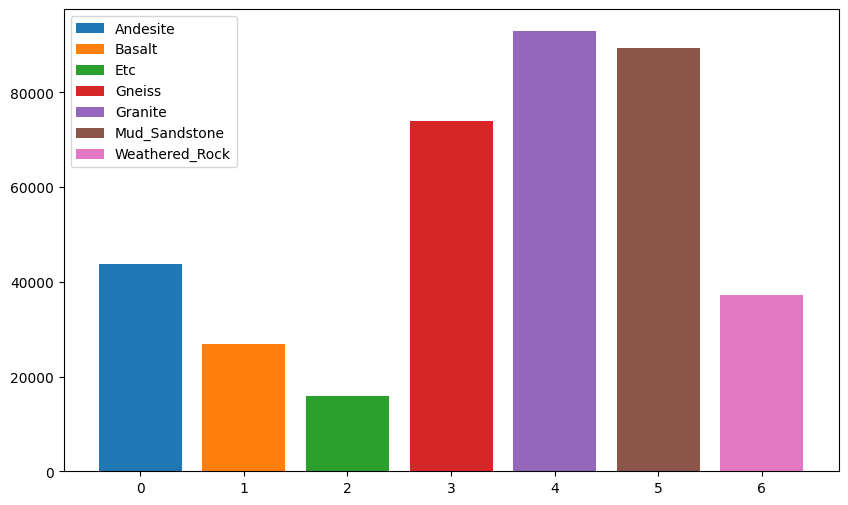

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for index, folder_name in enumerate(glob.glob(r'C:\Users\user\Downloads\open\open\train\*')):
    plt.bar(index, len(glob.glob(f'{folder_name}\\*')), label=os.path.basename(folder_name))
    print(f"{os.path.basename(folder_name):<10s}:\t{len(glob.glob(f'{folder_name}\\*'))}")

plt.legend()
plt.show()

In [ ]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.epoch = 50

        self.image_size = (224, 224)
        self.lr = 0.00005
        self.weight_decay = 0.001
    
        self.train_data_dir = r'C:\Users\user\Downloads\open\open\train'
        self.test_data_dir = r'C:\Users\user\Downloads\open\open\test'
        self.test_size = 0.2
        self.batch_size = 48
        self.sample_num = 30000

        self.visualize_epoch = 5
        self.visualize_save_dir = os.path.join(os.getcwd(), 'visualized_features')

config = Config()

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        targets = targets.view(-1, 1)

        log_p = log_probs.gather(1, targets).squeeze(1)
        p_t = probs.gather(1, targets).squeeze(1)

        if self.alpha is not None:
            if isinstance(self.alpha, (list, torch.Tensor)):
                alpha_t = self.alpha[targets.squeeze()]
            else:
                alpha_t = self.alpha
            loss = -alpha_t * (1 - p_t) ** self.gamma * log_p
        else:
            loss = -(1 - p_t) ** self.gamma * log_p

        return loss

In [7]:
class StratifiedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size

        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

        self.class_ratios = {
            label: len(idxs) / len(self.labels)
            for label, idxs in self.label_to_indices.items()
        }

        self.label_queues = {
            label: [] for label in self.label_to_indices
        }

        self._reset_label_queues()
        self.batches = self._create_batches()

    def _reset_label_queues(self):
        for label in self.label_to_indices:
            indices = self.label_to_indices[label]
            random.shuffle(indices)
            self.label_queues[label].extend(indices)

    def _create_batches(self):
        batches = []
        current_batch = []

        total_samples = len(self.labels)
        num_batches = math.ceil(total_samples / self.batch_size)

        for _ in range(num_batches):
            batch = []
            for label, ratio in self.class_ratios.items():
                n_samples = int(round(ratio * self.batch_size))

                # refill if empty
                if len(self.label_queues[label]) < n_samples:
                    remaining = self.label_to_indices[label][:]
                    random.shuffle(remaining)
                    self.label_queues[label].extend(remaining)

                for _ in range(n_samples):
                    if self.label_queues[label]:
                        batch.append(self.label_queues[label].pop())

            # 보정: 너무 작거나 클 경우
            if len(batch) > self.batch_size:
                batch = random.sample(batch, self.batch_size)
                
            elif len(batch) < self.batch_size:
                # 부족하면 다른 클래스에서 추가
                extra = self.batch_size - len(batch)
                flat_pool = sum(self.label_queues.values(), [])
                random.shuffle(flat_pool)
                batch += flat_pool[:extra]
                for idx in batch[-extra:]:
                    label = self.labels[idx]
                    if idx in self.label_queues[label]:
                        self.label_queues[label].remove(idx)

            batches.append(batch)

        return batches

    def __iter__(self):
        random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [8]:
item_list = glob.glob(rf"{config.train_data_dir}\*\*")
len(item_list)

380020

In [9]:
_num_classes = len(glob.glob(rf"{config.train_data_dir}\*"))
_num_classes

7

In [10]:
class SupMoCo(nn.Module):
    def __init__(self, encoder_q, encoder_k, K=65520, m=0.999, T=0.07):
        super(SupMoCo, self).__init__()
        self.K = K
        self.m = m
        self.T = T

        self.encoder_q = encoder_q
        self.encoder_k = encoder_k
        
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            dim = self.encoder_q(dummy).shape[1]

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # queue: embeddings + labels
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_labels", -1 * torch.ones(K, dtype=torch.long))  # -1 means invalid
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def dequeue_and_enqueue(self, keys, labels):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        self.queue[:, ptr:ptr + batch_size] = keys.T
        self.queue_labels[ptr:ptr + batch_size] = labels
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k, labels):
        q = self.encoder_q(im_q)
        q = F.normalize(q)
        with torch.no_grad():
            self.momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = F.normalize(k)

        l_pos = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        mask = self.queue_labels.expand(q.shape[0], -1).eq(labels.view(-1, 1))
        l_pos = l_pos[mask].view(q.shape[0], -1)

        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        l_neg = l_neg[~mask].view(q.shape[0], -1)

        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        labels = torch.zeros(q.shape[0], dtype=torch.long).to(q.device)

        self.dequeue_and_enqueue(k, labels)
        return logits, labels

In [14]:
backbone_q = timm.create_model('resnet50', pretrained=True, num_classes=0)
backbone_k = timm.create_model('resnet50', pretrained=True, num_classes=0)

In [15]:
model = SupMoCo(backbone_q, backbone_k)

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(0.5, 0.5)
])

valid_transform = transforms.Compose([ 
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(0.5, 0.5)
])

In [12]:
class custom_dataset(Dataset):
    def __init__(self, image_path_set, label_list, transform):
        # self.image_paths = [path for path, label in image_path_set]
        # self.labels = [label for path, label in image_path_set]
        self.image_paths = [path for path in image_path_set]
        self.labels = [os.path.basename(os.path.dirname(path)) for path in image_path_set]

        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        _image_path = self.image_paths[index]
        _image_label = self.label_list.index(self.labels[index])

        _image = Image.open(_image_path)
        _image_1 = self.transform(_image)
        _image_2 = self.transform(_image)

        return (_image_1, _image_2), _image_label, _image_path

In [13]:
class custom_data_factory():
    def __init__(self, paths, sample_num, train_transform, valid_transform):
        # self.paths = [(path, os.path.basename(os.path.dirname(path))) for path in paths]
        self.path_dict = {}
        for path in paths:
            _class = os.path.basename(os.path.dirname(path))
            if self.path_dict.get(_class) == None:
                self.path_dict[_class] = []

            self.path_dict[_class].append(path)

        self.selected_items = {_label: random.choices(_path_list, k=min(len(_path_list), sample_num)) for _label, _path_list in self.path_dict.items()}

        self.label_list = list(self.path_dict.keys())

        self.sample_num = sample_num
        self.train_transform = train_transform
        self.valid_transform = valid_transform

        self.losses = []

    def get_data_set(self):
        _item_list =  sum(self.selected_items.values(), [])
        random.shuffle(_item_list)

        train_index_set, valid_index_set = train_test_split(
            _item_list,
            test_size=config.test_size,
            stratify=sum([[_label] * len(_path_list) for _label, _path_list in self.selected_items.items()], []),
            shuffle=True,
            random_state=42
        )
        
        self.train_set = custom_dataset(train_index_set, self.label_list, self.train_transform)
        self.valid_set = custom_dataset(valid_index_set, self.label_list, self.valid_transform)

        print(f'Train set: {Counter(self.train_set.labels)}')
        print(f'Valid set: {Counter(self.valid_set.labels)}')

        return self.train_set, self.valid_set
    
    def get_data_loader(self):
        train_loader = DataLoader(
            self.train_set, pin_memory=True, 
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.train_set.labels], 
                batch_size=config.batch_size
            )
        )

        valid_loader = DataLoader(
            self.valid_set, pin_memory=True,
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.valid_set.labels], 
                batch_size=config.batch_size
            )
        )

        return train_loader, valid_loader
    
    def collect_losses(self, _paths, _labels, _losses):
        for _path, _label, _loss in zip(_paths, _labels, _losses):
            self.losses.append((_path, _label.item(), _loss.item()))

    def renew_data_loader(self, resample_ratio):
        selected_items_dict = {}
        for _path, _label, _loss in self.losses:
            _label = self.label_list[_label]
            if selected_items_dict.get(_label) == None:
                selected_items_dict[_label] = []

            selected_items_dict[_label].append((_path, _loss))
        
        selected_items = {}
        for _label, _path_list in selected_items_dict.items():
            _paths, _weights = zip(*_path_list)
            _weights = [(_weight - min(_weights))/(max(_weights)-min(_weights)) for _weight in _weights]

            selected_items[_label] = random.choices(_paths,
                                                    k=int(self.sample_num * (1-resample_ratio)),
                                                    weights=_weights)
        
        unselected_items = {_label: random.sample([_path for _path in _path_list if _path not in selected_items_dict[_label]],
                                                  k=min(len(_path_list), int(self.sample_num * resample_ratio))) for _label, _path_list in self.path_dict.items()}

        self.selected_items = {}
        for (_label, _selected_path_list), (_label, _unselected_path_list) in zip(selected_items.items(), unselected_items.items()):
            self.selected_items[_label] = []
            self.selected_items[_label].extend(_selected_path_list)
            # print(f'{_label}-selected: {len(_selected_path_list)}')
            self.selected_items[_label].extend(_unselected_path_list)
            # print(f'{_label}-unselected: {len(_unselected_path_list)}')
            # print()

        self.losses = []

        self.get_data_set()

        return self.get_data_loader()

In [14]:
data_factory = custom_data_factory(item_list, config.sample_num, train_transform, valid_transform)
data_factory.label_list

['Andesite',
 'Basalt',
 'Etc',
 'Gneiss',
 'Granite',
 'Mud_Sandstone',
 'Weathered_Rock']

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epoch)

NameError: name 'model' is not defined

In [16]:
def visualize_features(features_dict, epoch):
    os.makedirs(config.visualize_save_dir, exist_ok=True)

    all_features = np.concatenate([np.array(value) for label_name, value in features_dict.items()], axis=0)
    labels = sum([[label_name] * len(value) for label_name, value in features_dict.items()], [])
    
    n_samples = len(all_features)
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_2d = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], 
                    hue=labels)
    
    plt.title(f'Feature Space Visualization (t-SNE)\nSamples: {n_samples}, Perplexity: {perplexity}')
    plt.savefig(os.path.join(config.visualize_save_dir, f'feature_space_{epoch}.png'))
    plt.close()
    
    print("Visualization completed successfully")

In [17]:
def evaluate(model, epoch, valid_loader):
    model.eval()
    all_probs, all_labels = [], []
    features_dict = {label:[] for label in data_factory.label_list}
    
    with torch.no_grad():
        for images, labels, paths in tqdm(valid_loader, desc=f'Validating', leave=False):
            images, labels = images[0].to(config.device), labels.to(config.device)
            
            outputs, features = model(images, return_features=True)

            probs = F.softmax(outputs, dim=1)

            features_np = features.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for feat, label in zip(features_np, labels_np):
                features_dict[data_factory.label_list[label]].append(feat)

            all_probs.append(probs.cpu().numpy().flatten())
            all_labels.append(labels_np)
    
    if epoch % config.visualize_epoch == 0:
        visualize_features(features_dict, epoch)
        
    all_probs_roc = np.array(all_probs).reshape(-1, len(data_factory.label_list))
    all_probs = np.array([np.argmax(_pred) for _pred in all_probs_roc])
    all_labels = np.array(all_labels).flatten()

    return {
        'accuracy': accuracy_score(all_labels, all_probs),
        'precision': precision_score(all_labels, all_probs, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_probs, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_probs, average='weighted', zero_division=0),
        'roc_auc':roc_auc_score(all_labels, all_probs_roc, multi_class='ovr'),
        'confusion_matrix': confusion_matrix(all_labels, all_probs)
    }

In [19]:
model = torch.load('resnet_backbone_2.pt', weights_only=False)

model = model.to('cuda')

In [20]:
data_factory.get_data_set()
train_loader, valid_loader = data_factory.get_data_loader()

Train set: Counter({'Granite': 24114, 'Andesite': 24034, 'Gneiss': 24014, 'Mud_Sandstone': 23954, 'Weathered_Rock': 23907, 'Basalt': 21379, 'Etc': 12794})
Valid set: Counter({'Weathered_Rock': 6093, 'Mud_Sandstone': 6046, 'Gneiss': 5986, 'Andesite': 5966, 'Granite': 5886, 'Basalt': 5431, 'Etc': 3141})


KeyboardInterrupt: 

In [ ]:
train_history = {
    'loss': []
}

best_score = -1.0

for epoch in range(config.epoch):
    model.train()
    total_losses = []
    
    for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}'):
        image_1, image_2 = images[0].to(config.device), images[1].to(config.device)
        labels = labels.to(config.device)

        optimizer.zero_grad()
        
        logits, targets = model(image_1, image_2, labels)

        loss = F.cross_entropy(logits, targets, reduction='none')
        data_factory.collect_losses(paths, labels.cpu(), loss.cpu())
        
        loss.mean().backward()
        optimizer.step()

        total_losses.append(loss.mean().item())
        # scheduler.step()
        
    print(f'loss: {np.mean(total_losses)}')
        
    print("renew data_loader")
    train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.8)
    for label, selected_items in data_factory.selected_items.items():
        print(f'{label}: {len(selected_items)}', end='\n')
    print()

    train_history['loss'].append(np.mean(total_losses))
        
with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
    json.dump(train_history, json_file, indent=2, ensure_ascii=False)

Training epoch: 26/300: 100%|██████████| 3213/3213 [37:54<00:00,  1.41it/s]


loss: 16.24892827784054
renew data_loader
Train set: Counter({'Gneiss': 24059, 'Weathered_Rock': 24033, 'Granite': 23983, 'Mud_Sandstone': 23974, 'Basalt': 23965, 'Andesite': 23918, 'Etc': 17610})
Valid set: Counter({'Andesite': 6081, 'Basalt': 6034, 'Mud_Sandstone': 6025, 'Granite': 6016, 'Weathered_Rock': 5966, 'Gneiss': 5940, 'Etc': 4324})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 27/300: 100%|██████████| 3366/3366 [37:05<00:00,  1.51it/s]


loss: 18.445373031686476
renew data_loader
Train set: Counter({'Gneiss': 24095, 'Granite': 24015, 'Basalt': 24011, 'Mud_Sandstone': 24006, 'Andesite': 23957, 'Weathered_Rock': 23950, 'Etc': 17508})
Valid set: Counter({'Weathered_Rock': 6049, 'Andesite': 6042, 'Mud_Sandstone': 5993, 'Basalt': 5988, 'Granite': 5984, 'Gneiss': 5904, 'Etc': 4426})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 28/300: 100%|██████████| 3366/3366 [37:08<00:00,  1.51it/s]


loss: 19.76988786724587
renew data_loader
Train set: Counter({'Mud_Sandstone': 24183, 'Granite': 24103, 'Basalt': 24017, 'Andesite': 23979, 'Gneiss': 23938, 'Weathered_Rock': 23761, 'Etc': 17561})
Valid set: Counter({'Weathered_Rock': 6238, 'Gneiss': 6061, 'Andesite': 6020, 'Basalt': 5982, 'Granite': 5896, 'Mud_Sandstone': 5816, 'Etc': 4373})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 29/300: 100%|██████████| 3366/3366 [38:48<00:00,  1.45it/s]


loss: 18.387754623052697
renew data_loader
Train set: Counter({'Weathered_Rock': 24097, 'Andesite': 24065, 'Granite': 24044, 'Gneiss': 23988, 'Mud_Sandstone': 23943, 'Basalt': 23873, 'Etc': 17532})
Valid set: Counter({'Basalt': 6126, 'Mud_Sandstone': 6056, 'Gneiss': 6011, 'Granite': 5955, 'Andesite': 5934, 'Weathered_Rock': 5902, 'Etc': 4402})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 30/300: 100%|██████████| 3366/3366 [35:43<00:00,  1.57it/s]


loss: 19.003973667351037
renew data_loader
Train set: Counter({'Granite': 24099, 'Gneiss': 24037, 'Weathered_Rock': 24007, 'Andesite': 23987, 'Mud_Sandstone': 23972, 'Basalt': 23925, 'Etc': 17515})
Valid set: Counter({'Basalt': 6074, 'Mud_Sandstone': 6027, 'Andesite': 6012, 'Weathered_Rock': 5992, 'Gneiss': 5962, 'Granite': 5900, 'Etc': 4419})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 31/300: 100%|██████████| 3366/3366 [34:37<00:00,  1.62it/s]


loss: 18.995322199145455
renew data_loader
Train set: Counter({'Gneiss': 24081, 'Andesite': 23992, 'Mud_Sandstone': 23988, 'Basalt': 23986, 'Weathered_Rock': 23978, 'Granite': 23946, 'Etc': 17571})
Valid set: Counter({'Granite': 6053, 'Weathered_Rock': 6021, 'Basalt': 6013, 'Mud_Sandstone': 6011, 'Andesite': 6007, 'Gneiss': 5918, 'Etc': 4363})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 32/300: 100%|██████████| 3366/3366 [33:59<00:00,  1.65it/s]


loss: 18.73720254518415
renew data_loader
Train set: Counter({'Gneiss': 24065, 'Mud_Sandstone': 24044, 'Andesite': 23992, 'Weathered_Rock': 23979, 'Granite': 23979, 'Basalt': 23978, 'Etc': 17505})
Valid set: Counter({'Basalt': 6021, 'Weathered_Rock': 6020, 'Granite': 6020, 'Andesite': 6007, 'Mud_Sandstone': 5955, 'Gneiss': 5934, 'Etc': 4429})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 33/300: 100%|██████████| 3366/3366 [35:31<00:00,  1.58it/s]


loss: 18.978059875490548
renew data_loader
Train set: Counter({'Basalt': 24154, 'Mud_Sandstone': 24066, 'Gneiss': 23968, 'Weathered_Rock': 23947, 'Granite': 23939, 'Andesite': 23933, 'Etc': 17535})
Valid set: Counter({'Andesite': 6066, 'Granite': 6060, 'Weathered_Rock': 6052, 'Gneiss': 6031, 'Mud_Sandstone': 5933, 'Basalt': 5845, 'Etc': 4399})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 34/300: 100%|██████████| 3366/3366 [38:59<00:00,  1.44it/s]


loss: 19.271919763307803
renew data_loader
Train set: Counter({'Granite': 24104, 'Andesite': 24030, 'Basalt': 24026, 'Mud_Sandstone': 23995, 'Weathered_Rock': 23979, 'Gneiss': 23863, 'Etc': 17545})
Valid set: Counter({'Gneiss': 6136, 'Weathered_Rock': 6020, 'Mud_Sandstone': 6004, 'Basalt': 5973, 'Andesite': 5969, 'Granite': 5895, 'Etc': 4389})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 35/300: 100%|██████████| 3366/3366 [35:43<00:00,  1.57it/s]


loss: 19.75368185320994
renew data_loader
Train set: Counter({'Mud_Sandstone': 24049, 'Basalt': 24023, 'Granite': 24000, 'Gneiss': 23968, 'Weathered_Rock': 23929, 'Andesite': 23922, 'Etc': 17651})
Valid set: Counter({'Andesite': 6077, 'Weathered_Rock': 6070, 'Gneiss': 6031, 'Granite': 5999, 'Basalt': 5976, 'Mud_Sandstone': 5950, 'Etc': 4283})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 36/300: 100%|██████████| 3366/3366 [34:35<00:00,  1.62it/s]


loss: 18.602784792582195
renew data_loader
Train set: Counter({'Weathered_Rock': 24119, 'Granite': 24049, 'Gneiss': 24022, 'Mud_Sandstone': 24014, 'Basalt': 23967, 'Andesite': 23941, 'Etc': 17430})
Valid set: Counter({'Andesite': 6058, 'Basalt': 6032, 'Mud_Sandstone': 5985, 'Gneiss': 5977, 'Granite': 5950, 'Weathered_Rock': 5880, 'Etc': 4504})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 37/300: 100%|██████████| 3366/3366 [34:06<00:00,  1.65it/s]


loss: 18.872011726694453
renew data_loader
Train set: Counter({'Granite': 24076, 'Andesite': 24015, 'Gneiss': 23995, 'Mud_Sandstone': 23967, 'Basalt': 23966, 'Weathered_Rock': 23958, 'Etc': 17565})
Valid set: Counter({'Weathered_Rock': 6041, 'Basalt': 6033, 'Mud_Sandstone': 6032, 'Gneiss': 6004, 'Andesite': 5984, 'Granite': 5923, 'Etc': 4369})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 38/300: 100%|██████████| 3366/3366 [33:54<00:00,  1.65it/s]  


loss: 19.687568005535194
renew data_loader
Train set: Counter({'Weathered_Rock': 24098, 'Granite': 24043, 'Andesite': 24041, 'Gneiss': 23998, 'Mud_Sandstone': 23993, 'Basalt': 23906, 'Etc': 17463})
Valid set: Counter({'Basalt': 6093, 'Mud_Sandstone': 6006, 'Gneiss': 6001, 'Andesite': 5958, 'Granite': 5956, 'Weathered_Rock': 5901, 'Etc': 4471})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 39/300: 100%|██████████| 3366/3366 [33:23<00:00,  1.68it/s]


loss: 18.637869792684373
renew data_loader
Train set: Counter({'Mud_Sandstone': 24097, 'Basalt': 24031, 'Granite': 24030, 'Gneiss': 24015, 'Weathered_Rock': 23951, 'Andesite': 23902, 'Etc': 17516})
Valid set: Counter({'Andesite': 6097, 'Weathered_Rock': 6048, 'Gneiss': 5984, 'Granite': 5969, 'Basalt': 5968, 'Mud_Sandstone': 5902, 'Etc': 4418})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 40/300: 100%|██████████| 3366/3366 [31:51<00:00,  1.76it/s]


loss: 19.857363011818588
renew data_loader
Train set: Counter({'Granite': 24060, 'Weathered_Rock': 24054, 'Basalt': 23990, 'Andesite': 23976, 'Mud_Sandstone': 23958, 'Gneiss': 23935, 'Etc': 17569})
Valid set: Counter({'Gneiss': 6064, 'Mud_Sandstone': 6041, 'Andesite': 6023, 'Basalt': 6009, 'Weathered_Rock': 5945, 'Granite': 5939, 'Etc': 4365})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 41/300: 100%|██████████| 3366/3366 [31:41<00:00,  1.77it/s]


loss: 19.19603831698621
renew data_loader
Train set: Counter({'Mud_Sandstone': 24135, 'Gneiss': 24040, 'Granite': 23993, 'Weathered_Rock': 23973, 'Andesite': 23959, 'Basalt': 23918, 'Etc': 17524})
Valid set: Counter({'Basalt': 6081, 'Andesite': 6040, 'Weathered_Rock': 6026, 'Granite': 6006, 'Gneiss': 5959, 'Mud_Sandstone': 5864, 'Etc': 4410})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 42/300: 100%|██████████| 3366/3366 [31:35<00:00,  1.78it/s]


loss: 19.33025349681036
renew data_loader
Train set: Counter({'Gneiss': 24068, 'Basalt': 24023, 'Andesite': 24018, 'Granite': 24012, 'Weathered_Rock': 23936, 'Mud_Sandstone': 23900, 'Etc': 17585})
Valid set: Counter({'Mud_Sandstone': 6099, 'Weathered_Rock': 6063, 'Granite': 5987, 'Andesite': 5981, 'Basalt': 5976, 'Gneiss': 5931, 'Etc': 4349})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 43/300: 100%|██████████| 3366/3366 [31:29<00:00,  1.78it/s]


loss: 20.072528014633534
renew data_loader
Train set: Counter({'Andesite': 24062, 'Granite': 24061, 'Basalt': 24012, 'Mud_Sandstone': 23963, 'Gneiss': 23955, 'Weathered_Rock': 23928, 'Etc': 17561})
Valid set: Counter({'Weathered_Rock': 6071, 'Gneiss': 6044, 'Mud_Sandstone': 6036, 'Basalt': 5987, 'Granite': 5938, 'Andesite': 5937, 'Etc': 4373})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 44/300: 100%|██████████| 3366/3366 [31:25<00:00,  1.78it/s]


loss: 18.408389873753965
renew data_loader
Train set: Counter({'Granite': 24102, 'Basalt': 24051, 'Gneiss': 24044, 'Weathered_Rock': 24000, 'Andesite': 23977, 'Mud_Sandstone': 23930, 'Etc': 17438})
Valid set: Counter({'Mud_Sandstone': 6069, 'Andesite': 6022, 'Weathered_Rock': 5999, 'Gneiss': 5955, 'Basalt': 5948, 'Granite': 5897, 'Etc': 4496})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 45/300: 100%|██████████| 3366/3366 [31:22<00:00,  1.79it/s]


loss: 19.407048081190048
renew data_loader
Train set: Counter({'Andesite': 24074, 'Weathered_Rock': 24063, 'Granite': 23981, 'Gneiss': 23969, 'Basalt': 23959, 'Mud_Sandstone': 23947, 'Etc': 17549})
Valid set: Counter({'Mud_Sandstone': 6052, 'Basalt': 6040, 'Gneiss': 6030, 'Granite': 6018, 'Weathered_Rock': 5936, 'Andesite': 5925, 'Etc': 4385})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 46/300: 100%|██████████| 3366/3366 [31:21<00:00,  1.79it/s]


loss: 19.500719109533517
renew data_loader
Train set: Counter({'Weathered_Rock': 24122, 'Basalt': 24112, 'Mud_Sandstone': 24013, 'Granite': 23968, 'Andesite': 23957, 'Gneiss': 23815, 'Etc': 17555})
Valid set: Counter({'Gneiss': 6184, 'Andesite': 6042, 'Granite': 6031, 'Mud_Sandstone': 5986, 'Basalt': 5887, 'Weathered_Rock': 5877, 'Etc': 4379})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 47/300: 100%|██████████| 3366/3366 [31:17<00:00,  1.79it/s]


loss: 19.52287199436308
renew data_loader
Train set: Counter({'Gneiss': 24101, 'Granite': 24016, 'Weathered_Rock': 24012, 'Basalt': 23962, 'Andesite': 23936, 'Mud_Sandstone': 23885, 'Etc': 17630})
Valid set: Counter({'Mud_Sandstone': 6114, 'Andesite': 6063, 'Basalt': 6037, 'Weathered_Rock': 5987, 'Granite': 5983, 'Gneiss': 5898, 'Etc': 4304})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 48/300: 100%|██████████| 3366/3366 [31:13<00:00,  1.80it/s]


loss: 19.649123062636974
renew data_loader
Train set: Counter({'Mud_Sandstone': 24062, 'Basalt': 24060, 'Gneiss': 24022, 'Andesite': 23989, 'Weathered_Rock': 23982, 'Granite': 23958, 'Etc': 17469})
Valid set: Counter({'Granite': 6041, 'Weathered_Rock': 6017, 'Andesite': 6010, 'Gneiss': 5977, 'Basalt': 5939, 'Mud_Sandstone': 5937, 'Etc': 4465})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 49/300: 100%|██████████| 3366/3366 [31:11<00:00,  1.80it/s]


loss: 18.304261600836643
renew data_loader
Train set: Counter({'Weathered_Rock': 24077, 'Basalt': 24047, 'Granite': 24032, 'Mud_Sandstone': 24024, 'Andesite': 23993, 'Gneiss': 23977, 'Etc': 17392})
Valid set: Counter({'Gneiss': 6022, 'Andesite': 6006, 'Mud_Sandstone': 5975, 'Granite': 5967, 'Basalt': 5952, 'Weathered_Rock': 5922, 'Etc': 4542})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 50/300: 100%|██████████| 3366/3366 [31:11<00:00,  1.80it/s]


loss: 18.69168932410981
renew data_loader
Train set: Counter({'Mud_Sandstone': 24099, 'Basalt': 24069, 'Gneiss': 24039, 'Granite': 23943, 'Weathered_Rock': 23929, 'Andesite': 23884, 'Etc': 17579})
Valid set: Counter({'Andesite': 6115, 'Weathered_Rock': 6070, 'Granite': 6056, 'Gneiss': 5960, 'Basalt': 5930, 'Mud_Sandstone': 5900, 'Etc': 4355})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 51/300: 100%|██████████| 3366/3366 [31:15<00:00,  1.80it/s]


loss: 19.129082853143867
renew data_loader
Train set: Counter({'Weathered_Rock': 24123, 'Granite': 24030, 'Mud_Sandstone': 23988, 'Gneiss': 23963, 'Basalt': 23945, 'Andesite': 23943, 'Etc': 17550})
Valid set: Counter({'Andesite': 6056, 'Basalt': 6054, 'Gneiss': 6036, 'Mud_Sandstone': 6011, 'Granite': 5969, 'Weathered_Rock': 5876, 'Etc': 4384})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 52/300: 100%|██████████| 3366/3366 [31:08<00:00,  1.80it/s]


loss: 19.521501549637467
renew data_loader
Train set: Counter({'Mud_Sandstone': 24145, 'Andesite': 24056, 'Basalt': 24032, 'Weathered_Rock': 23978, 'Granite': 23926, 'Gneiss': 23920, 'Etc': 17485})
Valid set: Counter({'Gneiss': 6079, 'Granite': 6073, 'Weathered_Rock': 6021, 'Basalt': 5967, 'Andesite': 5943, 'Mud_Sandstone': 5854, 'Etc': 4449})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 53/300: 100%|██████████| 3366/3366 [31:08<00:00,  1.80it/s]


loss: 19.3495420936453
renew data_loader
Train set: Counter({'Weathered_Rock': 24132, 'Gneiss': 24039, 'Mud_Sandstone': 24037, 'Basalt': 23997, 'Granite': 23928, 'Andesite': 23894, 'Etc': 17515})
Valid set: Counter({'Andesite': 6105, 'Granite': 6071, 'Basalt': 6002, 'Mud_Sandstone': 5962, 'Gneiss': 5960, 'Weathered_Rock': 5867, 'Etc': 4419})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 54/300: 100%|██████████| 3366/3366 [31:07<00:00,  1.80it/s]


loss: 18.80822912483646
renew data_loader
Train set: Counter({'Basalt': 24053, 'Granite': 24043, 'Gneiss': 24020, 'Mud_Sandstone': 24015, 'Weathered_Rock': 23967, 'Andesite': 23956, 'Etc': 17488})
Valid set: Counter({'Andesite': 6043, 'Weathered_Rock': 6032, 'Mud_Sandstone': 5984, 'Gneiss': 5979, 'Granite': 5956, 'Basalt': 5946, 'Etc': 4446})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 55/300: 100%|██████████| 3366/3366 [35:49<00:00,  1.57it/s]


loss: 19.26787591334687
renew data_loader
Train set: Counter({'Mud_Sandstone': 24165, 'Basalt': 24056, 'Andesite': 24044, 'Gneiss': 23959, 'Weathered_Rock': 23915, 'Granite': 23867, 'Etc': 17536})
Valid set: Counter({'Granite': 6132, 'Weathered_Rock': 6084, 'Gneiss': 6040, 'Andesite': 5955, 'Basalt': 5943, 'Mud_Sandstone': 5834, 'Etc': 4398})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 56/300: 100%|██████████| 3366/3366 [36:12<00:00,  1.55it/s]


loss: 18.715631051497027
renew data_loader
Train set: Counter({'Basalt': 24027, 'Gneiss': 24017, 'Mud_Sandstone': 23995, 'Weathered_Rock': 23979, 'Andesite': 23978, 'Granite': 23963, 'Etc': 17583})
Valid set: Counter({'Granite': 6036, 'Andesite': 6021, 'Weathered_Rock': 6020, 'Mud_Sandstone': 6004, 'Gneiss': 5982, 'Basalt': 5972, 'Etc': 4351})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 57/300: 100%|██████████| 3366/3366 [33:54<00:00,  1.65it/s]


loss: 19.43587905823724
renew data_loader
Train set: Counter({'Mud_Sandstone': 24081, 'Granite': 24060, 'Weathered_Rock': 24027, 'Andesite': 23976, 'Gneiss': 23936, 'Basalt': 23851, 'Etc': 17611})
Valid set: Counter({'Basalt': 6148, 'Gneiss': 6063, 'Andesite': 6023, 'Weathered_Rock': 5972, 'Granite': 5939, 'Mud_Sandstone': 5918, 'Etc': 4323})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 58/300: 100%|██████████| 3366/3366 [33:06<00:00,  1.69it/s]


loss: 20.01094472231216
renew data_loader
Train set: Counter({'Gneiss': 24081, 'Mud_Sandstone': 24033, 'Granite': 24021, 'Weathered_Rock': 23973, 'Andesite': 23949, 'Basalt': 23896, 'Etc': 17589})
Valid set: Counter({'Basalt': 6103, 'Andesite': 6050, 'Weathered_Rock': 6026, 'Granite': 5978, 'Mud_Sandstone': 5966, 'Gneiss': 5918, 'Etc': 4345})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 59/300: 100%|██████████| 3366/3366 [32:34<00:00,  1.72it/s]


loss: 19.55011619844397
renew data_loader
Train set: Counter({'Mud_Sandstone': 24086, 'Basalt': 24076, 'Andesite': 24037, 'Weathered_Rock': 24019, 'Granite': 23926, 'Gneiss': 23871, 'Etc': 17527})
Valid set: Counter({'Gneiss': 6128, 'Granite': 6073, 'Weathered_Rock': 5980, 'Andesite': 5962, 'Basalt': 5923, 'Mud_Sandstone': 5913, 'Etc': 4407})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 60/300: 100%|██████████| 3366/3366 [32:12<00:00,  1.74it/s]


loss: 19.272921835887452
renew data_loader


KeyboardInterrupt: 

In [26]:

with open(os.path.join(os.getcwd(), 'train_history_2.json'), 'w', encoding='utf-8-sig') as json_file:
    json.dump(train_history, json_file, indent=2, ensure_ascii=False)

In [27]:
torch.save(model, 'resnet_backbone_2.pt')

In [23]:
backbone = torch.load('resnet_backbone_2.pt', weights_only=False)
backbone

SupMoCo(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mo

In [21]:
class custom_model(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()

        if isinstance(backbone, str):
            self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)
        elif isinstance(backbone, nn.Module):
            self.backbone = backbone.to('cpu')
        else:
            raise

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            num_features = self.backbone(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(num_features, 2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 256),
            nn.GELU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_features=False):
        features = self.backbone(x)

        if return_features:
            return self.head(features), features
        
        return self.head(features)
    
    def forward_features(self, x):
        return self.backbone(x)

In [24]:
model = custom_model(backbone.encoder_q, num_classes=_num_classes)
model

custom_model(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05

In [26]:
def evaluate(model, epoch, valid_loader):
    model.eval()
    all_probs, all_labels = [], []
    features_dict = {label:[] for label in data_factory.label_list}
    
    with torch.no_grad():
        for images, labels, paths in tqdm(valid_loader, desc=f'Validating', leave=False):
            images, labels = images[0].to(config.device), labels.to(config.device)
            
            outputs, features = model(images, return_features=True)

            probs = F.softmax(outputs, dim=1)

            features_np = features.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for feat, label in zip(features_np, labels_np):
                features_dict[data_factory.label_list[label]].append(feat)

            all_probs.append(probs.cpu().numpy().flatten())
            all_labels.append(labels_np)
    
    if epoch % config.visualize_epoch == 0:
        visualize_features(features_dict, epoch)
        
    all_probs_roc = np.array(all_probs).reshape(-1, len(data_factory.label_list))
    all_probs = np.array([np.argmax(_pred) for _pred in all_probs_roc])
    all_labels = np.array(all_labels).flatten()

    return {
        'accuracy': accuracy_score(all_labels, all_probs),
        'precision': precision_score(all_labels, all_probs, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_probs, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_probs, average='weighted', zero_division=0),
        'roc_auc':roc_auc_score(all_labels, all_probs_roc, multi_class='ovr'),
        'confusion_matrix': confusion_matrix(all_labels, all_probs)
    }

In [27]:
def visualize_features(features_dict, epoch):
    os.makedirs(config.visualize_save_dir, exist_ok=True)

    all_features = np.concatenate([np.array(value) for label_name, value in features_dict.items()], axis=0)
    labels = sum([[label_name] * len(value) for label_name, value in features_dict.items()], [])
    
    n_samples = len(all_features)
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_2d = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], 
                    hue=labels)
    
    plt.title(f'Feature Space Visualization (t-SNE)\nSamples: {n_samples}, Perplexity: {perplexity}')
    plt.savefig(os.path.join(config.visualize_save_dir, f'feature_space_{epoch}.png'))
    plt.close()
    
    print("Visualization completed successfully")
        

In [33]:
train_history = {
    'loss': []
}

best_score = -1.0

criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epoch)

data_factory.get_data_set()
train_loader, valid_loader = data_factory.get_data_loader()

model.to('cuda')

for epoch in range(config.epoch):
    model.train()
    total_losses = []
    
    for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}'):
        image_1, image_2 = images[0].to(config.device), images[1].to(config.device)
        labels = labels.to(config.device)

        optimizer.zero_grad()
        
        outputs = model(image_1)

        loss = criterion(outputs, labels)
        loss.mean().backward()
        optimizer.step()
        
        total_losses.append(loss.mean().item())
        scheduler.step()
        
        data_factory.collect_losses(paths, labels.cpu(), loss.cpu())
    
    valid_results = evaluate(model, epoch, valid_loader=valid_loader)
    if best_score < valid_results['f1']:
        best_score = valid_results['f1']
        torch.save(model, 'best_model.pt')

    print(f"epoch {epoch+1:>3d}", end='/')
    print(f"accuracy: {valid_results['accuracy']}", end=' / ')
    print(f"precision: {valid_results['precision']}", end=' / ')
    print(f"recall: {valid_results['recall']}", end=' / ')
    print(f"f1: {valid_results['f1']}", end=' / ')
    print(f"roc_auc: {valid_results['roc_auc']}")
    print(f"{valid_results['confusion_matrix']}")

    train_history[epoch] = valid_results
        
    print("renew data_loader")
    train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.8)
    for label, selected_items in data_factory.selected_items.items():
        print(f'{label}: {len(selected_items)}', end='\n')
    print()

    train_history['loss'].append(np.mean(total_losses))
        
with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
    json.dump(train_history, json_file, indent=2, ensure_ascii=False)

Train set: Counter({'Gneiss': 24035, 'Andesite': 24029, 'Granite': 24028, 'Weathered_Rock': 23941, 'Mud_Sandstone': 23921, 'Basalt': 21488, 'Etc': 12754})
Valid set: Counter({'Mud_Sandstone': 6079, 'Weathered_Rock': 6059, 'Granite': 5972, 'Andesite': 5971, 'Gneiss': 5965, 'Basalt': 5322, 'Etc': 3181})


Training epoch: 1/50: 100%|██████████| 3213/3213 [1:05:18<00:00,  1.22s/it]


Visualization completed successfully
epoch   1/accuracy: 0.7510105721393034 / precision: 0.7315049976190651 / recall: 0.7510105721393034 / f1: 0.7365611311729908 / roc_auc: 0.93968511580307
[[4602   42  108   61   10  728   77]
 [   2 5443    1    4    1  137   40]
 [ 210   52  443  999  332  652  528]
 [  44   52  212 4119  393  485  323]
 [  17    1   92  485 4793    5  235]
 [ 580  408  130  451   12 4653  198]
 [ 137  233  291  187  318  336 4930]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 24090, 'Andesite': 24026, 'Granite': 24007, 'Gneiss': 23984, 'Basalt': 23929, 'Weathered_Rock': 23891, 'Etc': 17615})
Valid set: Counter({'Weathered_Rock': 6108, 'Basalt': 6070, 'Gneiss': 6015, 'Granite': 5992, 'Andesite': 5973, 'Mud_Sandstone': 5909, 'Etc': 4319})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 2/50: 100%|██████████| 3366/3366 [1:05:07<00:00,  1.16s/it]


epoch   2/accuracy: 0.727756334125099 / precision: 0.7176254591048645 / recall: 0.727756334125099 / f1: 0.7198563237343424 / roc_auc: 0.9380741974296768
[[4789   64  185  116   46  559  247]
 [  33 5724    4   21    2  177   68]
 [ 339   87 1393  930  458  539  556]
 [ 107   55  362 4449  405  323  318]
 [  99    4  255  401 4960    4  297]
 [ 762  301  220  663   29 3689  360]
 [ 336  208  386  149  317  211 4409]]
renew data_loader
Train set: Counter({'Andesite': 24129, 'Gneiss': 24127, 'Weathered_Rock': 24006, 'Basalt': 23953, 'Granite': 23935, 'Mud_Sandstone': 23891, 'Etc': 17501})
Valid set: Counter({'Mud_Sandstone': 6108, 'Granite': 6064, 'Basalt': 6046, 'Weathered_Rock': 5993, 'Gneiss': 5872, 'Andesite': 5870, 'Etc': 4433})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 3/50: 100%|██████████| 3366/3366 [1:02:59<00:00,  1.12s/it]


epoch   3/accuracy: 0.6974712984956453 / precision: 0.6938814241513306 / recall: 0.6974712984956453 / f1: 0.6935271762784736 / roc_auc: 0.928651630287211
[[4491  129  255  215   58  581  272]
 [  31 5534    2  105   36  289   18]
 [ 321  108 1551  952  384  517  474]
 [  93   79  468 4479  343  257  290]
 [ 128   24  400  449 4569    4  474]
 [ 663  285  339  843   34 3606  251]
 [ 354  295  402  388  283  334 3959]]
renew data_loader
Train set: Counter({'Weathered_Rock': 24039, 'Gneiss': 24014, 'Granite': 23998, 'Andesite': 23989, 'Mud_Sandstone': 23987, 'Basalt': 23954, 'Etc': 17561})
Valid set: Counter({'Basalt': 6045, 'Mud_Sandstone': 6012, 'Andesite': 6010, 'Granite': 6001, 'Gneiss': 5985, 'Weathered_Rock': 5960, 'Etc': 4373})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 4/50: 100%|██████████| 3366/3366 [1:02:16<00:00,  1.11s/it]


epoch   4/accuracy: 0.6968032462391133 / precision: 0.6900317127630177 / recall: 0.6968032462391133 / f1: 0.6892544733099838 / roc_auc: 0.9245881610735486
[[4602  124  154  329   72  431  319]
 [  15 5556    0   82    5  242  127]
 [ 343   79 1251 1104  500  469  562]
 [ 178   62  353 4374  326  264  458]
 [ 165   52  325  487 4639    5  334]
 [ 750  273  318  800   62 3491  339]
 [ 354  165  285  306  376  260 4249]]
renew data_loader
Train set: Counter({'Granite': 24081, 'Weathered_Rock': 24041, 'Gneiss': 24038, 'Basalt': 24037, 'Andesite': 23950, 'Mud_Sandstone': 23894, 'Etc': 17501})
Valid set: Counter({'Mud_Sandstone': 6105, 'Andesite': 6049, 'Basalt': 5962, 'Gneiss': 5961, 'Weathered_Rock': 5958, 'Granite': 5918, 'Etc': 4433})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 5/50: 100%|██████████| 3366/3366 [1:01:55<00:00,  1.10s/it]


epoch   5/accuracy: 0.7011826999208234 / precision: 0.6946785033969219 / recall: 0.7011826999208234 / f1: 0.6943603738379536 / roc_auc: 0.9270548787539595
[[4514  143  191  337   59  476  304]
 [  14 5719    0   34    3  192   59]
 [ 328  117 1358 1036  424  471  584]
 [ 183   91  379 4442  339  216  389]
 [ 136   41  397  456 4542   10  407]
 [ 713  289  347  692   41 3542  383]
 [ 322  224  288  425  337  200 4222]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 24069, 'Gneiss': 24035, 'Weathered_Rock': 24012, 'Basalt': 24002, 'Granite': 23925, 'Andesite': 23911, 'Etc': 17588})
Valid set: Counter({'Andesite': 6088, 'Granite': 6074, 'Basalt': 5997, 'Weathered_Rock': 5987, 'Gneiss': 5964, 'Mud_Sandstone': 5930, 'Etc': 4346})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 6/50: 100%|██████████| 3366/3366 [1:04:53<00:00,  1.16s/it]


Visualization completed successfully
epoch   6/accuracy: 0.7037064528899446 / precision: 0.696214935594063 / recall: 0.7037064528899446 / f1: 0.6958186163586969 / roc_auc: 0.9281803156940717
[[4436  116  156  312   55  584  353]
 [  25 5716    0   76    3  162   41]
 [ 275  103 1201 1037  423  581  685]
 [ 164   45  302 4435  386  244  459]
 [ 114   38  421  406 4525   91  433]
 [ 632  226  240  668   57 3838  346]
 [ 255  222  220  424  311  284 4290]]
renew data_loader
Train set: Counter({'Granite': 24070, 'Basalt': 24050, 'Gneiss': 24001, 'Andesite': 23993, 'Mud_Sandstone': 23953, 'Weathered_Rock': 23948, 'Etc': 17527})
Valid set: Counter({'Weathered_Rock': 6051, 'Mud_Sandstone': 6046, 'Andesite': 6006, 'Gneiss': 5998, 'Basalt': 5949, 'Granite': 5929, 'Etc': 4407})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 7/50: 100%|██████████| 3366/3366 [1:05:59<00:00,  1.18s/it]


epoch   7/accuracy: 0.6998713380839272 / precision: 0.6986557175775256 / recall: 0.6998713380839272 / f1: 0.6957874984561192 / roc_auc: 0.927148404638972
[[4262  128  214  383  111  611  309]
 [   6 5770    0   42    5  173   17]
 [ 239   87 1495 1165  428  516  370]
 [ 129   83  362 4610  292  250  285]
 [ 119   32  413  468 4517  157  315]
 [ 531  193  387  744   42 3919  208]
 [ 268  221  465  467  360  535 3713]]
renew data_loader
Train set: Counter({'Andesite': 24103, 'Granite': 24080, 'Weathered_Rock': 24019, 'Basalt': 23997, 'Gneiss': 23945, 'Mud_Sandstone': 23925, 'Etc': 17473})
Valid set: Counter({'Mud_Sandstone': 6074, 'Gneiss': 6054, 'Basalt': 6002, 'Weathered_Rock': 5980, 'Granite': 5919, 'Andesite': 5896, 'Etc': 4461})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 8/50: 100%|██████████| 3366/3366 [1:03:36<00:00,  1.13s/it]


epoch   8/accuracy: 0.705512668250198 / precision: 0.699017731311957 / recall: 0.705512668250198 / f1: 0.6994477085247275 / roc_auc: 0.9298755668192379
[[4351  150  170  275  118  601  356]
 [   3 5818    0   20    4   78   80]
 [ 302  128 1461 1037  374  449  544]
 [ 157   78  395 4440  413  172  365]
 [ 131   18  425  422 4561  184  276]
 [ 548  323  339  714   73 3644  386]
 [ 282  171  321  389  386  245 4239]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 24160, 'Gneiss': 24070, 'Andesite': 23983, 'Basalt': 23939, 'Granite': 23934, 'Weathered_Rock': 23908, 'Etc': 17548})
Valid set: Counter({'Weathered_Rock': 6091, 'Granite': 6065, 'Basalt': 6060, 'Andesite': 6016, 'Gneiss': 5929, 'Mud_Sandstone': 5839, 'Etc': 4386})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 9/50: 100%|██████████| 3366/3366 [1:02:47<00:00,  1.12s/it]


epoch   9/accuracy: 0.7077642517814727 / precision: 0.7006085900192107 / recall: 0.7077642517814727 / f1: 0.7003236106093339 / roc_auc: 0.9322438074670429
[[4324  159  181  289  162  564  337]
 [   6 5904    0   23    2   54   34]
 [ 287  117 1424  961  402  559  559]
 [ 158   59  315 4475  363  275  383]
 [  86   12  348  467 4582  106  411]
 [ 622  320  220  659   70 3686  432]
 [ 268  213  282  424  373  249 4210]]
renew data_loader
Train set: Counter({'Gneiss': 24109, 'Basalt': 24087, 'Granite': 24037, 'Weathered_Rock': 23977, 'Mud_Sandstone': 23955, 'Andesite': 23865, 'Etc': 17512})
Valid set: Counter({'Andesite': 6134, 'Mud_Sandstone': 6044, 'Weathered_Rock': 6022, 'Granite': 5962, 'Basalt': 5912, 'Gneiss': 5890, 'Etc': 4422})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 10/50: 100%|██████████| 3366/3366 [1:02:22<00:00,  1.11s/it]


epoch  10/accuracy: 0.7109807996832938 / precision: 0.7042065153252944 / recall: 0.7109807996832938 / f1: 0.7060474751244478 / roc_auc: 0.9323230752523887
[[4553   70  162  208  141  625  262]
 [  26 5752    2   15   12  178   28]
 [ 408   93 1541  733  407  553  558]
 [ 232   45  403 4134  461  336  419]
 [ 128    2  396  339 4511  215  427]
 [ 629  148  260  580   64 3983  366]
 [ 338  178  300  307  343  284 4261]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 24072, 'Weathered_Rock': 24026, 'Andesite': 24024, 'Granite': 23945, 'Gneiss': 23941, 'Basalt': 23934, 'Etc': 17600})
Valid set: Counter({'Basalt': 6065, 'Gneiss': 6058, 'Granite': 6054, 'Andesite': 5975, 'Weathered_Rock': 5973, 'Mud_Sandstone': 5927, 'Etc': 4334})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 11/50: 100%|██████████| 3366/3366 [1:01:55<00:00,  1.10s/it]


Visualization completed successfully
epoch  11/accuracy: 0.7079374505146476 / precision: 0.7029940169221305 / recall: 0.7079374505146476 / f1: 0.7035783986178188 / roc_auc: 0.9347431257391143
[[4342  102  252  258  112  549  413]
 [  21 5868    1   17    2   74   35]
 [ 252  103 1656  814  454  426  596]
 [ 185   70  480 4222  378  226  459]
 [ 135    6  352  357 4418  292  475]
 [ 596  256  289  647   71 3734  421]
 [ 214  192  343  329  334  216 4372]]
renew data_loader
Train set: Counter({'Granite': 24102, 'Basalt': 24101, 'Mud_Sandstone': 24054, 'Andesite': 23961, 'Gneiss': 23950, 'Weathered_Rock': 23812, 'Etc': 17562})
Valid set: Counter({'Weathered_Rock': 6187, 'Gneiss': 6049, 'Andesite': 6038, 'Mud_Sandstone': 5945, 'Basalt': 5898, 'Granite': 5897, 'Etc': 4372})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 12/50: 100%|██████████| 3366/3366 [1:02:01<00:00,  1.11s/it]


epoch  12/accuracy: 0.7100405779889153 / precision: 0.706097169094158 / recall: 0.7100405779889153 / f1: 0.7067138322877993 / roc_auc: 0.9320541668133052
[[4425   88  242  245   79  656  287]
 [  23 5771    0   17    2   84   95]
 [ 257   68 1674  855  432  445  571]
 [ 144   62  437 4311  361  301  415]
 [  80    5  353  640 4384  284  271]
 [ 559  213  380  552   71 3883  365]
 [ 329  131  330  327  435  228 4249]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 24063, 'Basalt': 24026, 'Weathered_Rock': 23991, 'Gneiss': 23976, 'Andesite': 23961, 'Granite': 23917, 'Etc': 17608})
Valid set: Counter({'Granite': 6082, 'Andesite': 6038, 'Gneiss': 6023, 'Weathered_Rock': 6008, 'Basalt': 5973, 'Mud_Sandstone': 5936, 'Etc': 4326})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 13/50: 100%|██████████| 3366/3366 [1:01:35<00:00,  1.10s/it]


epoch  13/accuracy: 0.7177602929532858 / precision: 0.7167845525498351 / recall: 0.7177602929532858 / f1: 0.7137853444073615 / roc_auc: 0.9384123398942024
[[4555   91  136  374   82  593  200]
 [  10 5747    0   13    0  130  138]
 [ 332   62 1602 1056  353  357  532]
 [ 131   48  364 4636  282  205  353]
 [ 108    5  299  574 4556   84  396]
 [ 571  190  340  779   32 3789  305]
 [ 445  127  334  390  358  228 4124]]
renew data_loader
Train set: Counter({'Weathered_Rock': 24081, 'Andesite': 24054, 'Gneiss': 24031, 'Mud_Sandstone': 24021, 'Granite': 23905, 'Basalt': 23891, 'Etc': 17559})
Valid set: Counter({'Basalt': 6108, 'Granite': 6094, 'Mud_Sandstone': 5978, 'Gneiss': 5968, 'Andesite': 5945, 'Weathered_Rock': 5918, 'Etc': 4375})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 14/50: 100%|██████████| 3366/3366 [1:01:43<00:00,  1.10s/it]


epoch  14/accuracy: 0.7218923198733175 / precision: 0.7178023952413524 / recall: 0.7218923198733175 / f1: 0.7170210908736532 / roc_auc: 0.9412330601361336
[[4725   70  198  275   48  450  250]
 [  31 5879    0    7    0   74   24]
 [ 328   83 1638  996  323  461  486]
 [ 183   77  364 4527  288  284  284]
 [  74    4  430  493 4486  149  383]
 [ 773  256  258  548   44 3839  309]
 [ 363  170  340  481  344  237 4082]]
renew data_loader
Train set: Counter({'Andesite': 24050, 'Basalt': 24035, 'Granite': 24035, 'Mud_Sandstone': 24022, 'Gneiss': 24016, 'Weathered_Rock': 23899, 'Etc': 17485})
Valid set: Counter({'Weathered_Rock': 6100, 'Gneiss': 5983, 'Mud_Sandstone': 5977, 'Granite': 5964, 'Basalt': 5964, 'Andesite': 5949, 'Etc': 4449})
Andesite: 29999
Basalt: 29999
Etc: 21934
Gneiss: 29999
Granite: 29999
Mud_Sandstone: 29999
Weathered_Rock: 29999



Training epoch: 15/50:  60%|██████    | 2027/3366 [38:05<25:09,  1.13s/it] 


KeyboardInterrupt: 

In [34]:
torch.save(model, 'model_3.pt')